In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import gc  # Garbage collector (RAM temizleme)

print("✅ Kütüphaneler yüklendi")
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

✅ Kütüphaneler yüklendi
pandas version: 2.3.3
numpy version: 2.0.2


In [2]:
DATA_PATH = '../data/processed/multiclass_dataset.parquet'

# Parquet metadata'yı oku (dosyayı yüklemeden)
parquet_file = pq.ParquetFile(DATA_PATH)

print("📊 Parquet Dosya Bilgileri:")
print(f"  Satır sayısı: {parquet_file.metadata.num_rows:,}")
print(f"  Kolon sayısı: {parquet_file.metadata.num_columns}")
print(f"  Dosya boyutu: {Path(DATA_PATH).stat().st_size / (1024**2):.2f} MB")

# Kolon isimleri
schema = parquet_file.schema
print(f"\n  Kolonlar (ilk 10): {schema.names[:10]}")

📊 Parquet Dosya Bilgileri:
  Satır sayısı: 2,438,052
  Kolon sayısı: 122
  Dosya boyutu: 477.45 MB

  Kolonlar (ilk 10): ['flow_id', 'timestamp', 'src_ip', 'src_port', 'dst_ip', 'dst_port', 'protocol', 'duration', 'packets_count', 'fwd_packets_count']


In [4]:
# =====================================================
# CELL 3: PARQUET'İ YÜKLE VE SHUFFLE ET
# =====================================================

print("\n📂 Parquet yükleniyor...")

try:
    # Tüm veriyi yükle
    df = pd.read_parquet(DATA_PATH, engine='pyarrow')
    
    print(f"✅ Parquet yüklendi!")
    print(f"  Shape: {df.shape}")
    print(f"  Memory: {df.memory_usage(deep=True).sum() / (1024**2):.0f} MB")
    
    # Veri kalitesi kontrolü
    print(f"\n🔍 Veri kalitesi...")
    missing = df.isnull().sum().sum()
    inf_count = np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
    
    print(f"  Missing values: {missing:,}")
    print(f"  Infinite values: {inf_count:,}")
    
    # Temizlik
    if missing > 0:
        df = df.fillna(0)
    if inf_count > 0:
        df = df.replace([np.inf, -np.inf], 0)
    
    # Shuffle
    print(f"\n🔀 Shuffle yapılıyor...")
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"✅ Hazır!")
    
    PARQUET_LOADED = True
    
except MemoryError as e:
    print(f"❌ RAM yetersiz: {e}")
    print(f"⚙️  Chunk yöntemi kullanılacak...")
    PARQUET_LOADED = False


📂 Parquet yükleniyor...
✅ Parquet yüklendi!
  Shape: (2438052, 122)
  Memory: 3117 MB

🔍 Veri kalitesi...
  Missing values: 0
  Infinite values: 0

🔀 Shuffle yapılıyor...
✅ Hazır!


In [5]:
# =====================================================
# CELL 4: SHUFFLELENMİŞ VERİYİ KAYDET
# =====================================================

OUTPUT_PATH = '../data/processed/multiclass_dataset_shuffled.parquet'

print(f"\n💾 Shuffled veri kaydediliyor: {OUTPUT_PATH}")

# Parquet olarak kaydet
df.to_parquet(OUTPUT_PATH, engine='pyarrow', compression='snappy', index=False)

# Dosya boyutu
output_size_mb = Path(OUTPUT_PATH).stat().st_size / (1024**2)

print(f"✅ Kaydedildi!")
print(f"  📦 Dosya boyutu: {output_size_mb:.2f} MB")
print(f"  📊 Satır sayısı: {len(df):,}")
print(f"  📝 Kolon sayısı: {len(df.columns)}")


💾 Shuffled veri kaydediliyor: ../data/processed/multiclass_dataset_shuffled.parquet
✅ Kaydedildi!
  📦 Dosya boyutu: 575.39 MB
  📊 Satır sayısı: 2,438,052
  📝 Kolon sayısı: 122


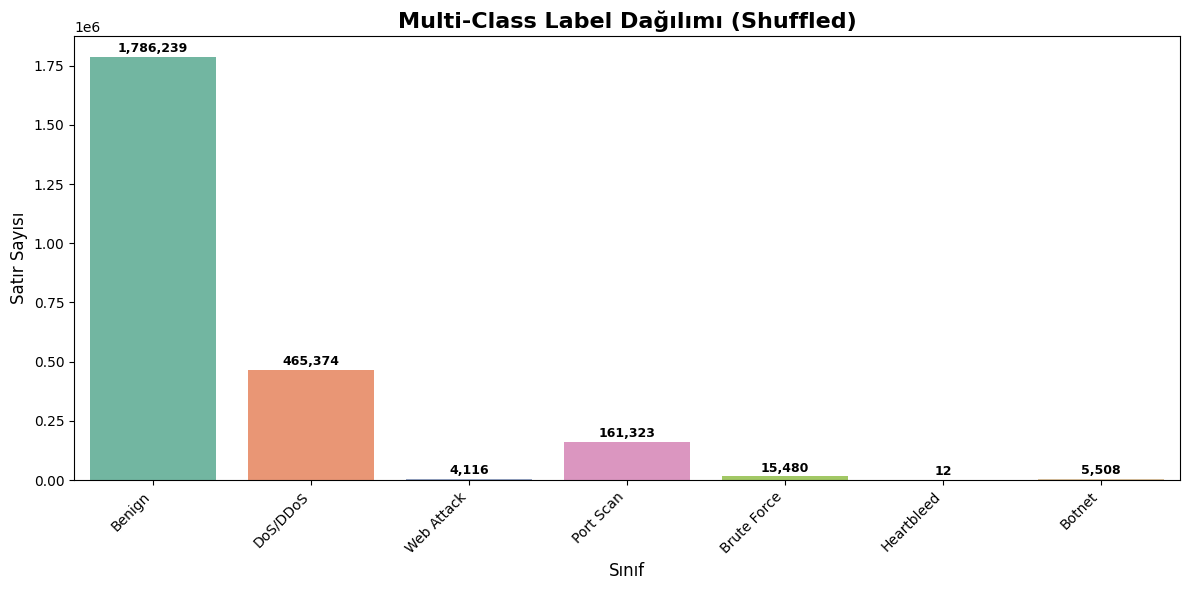

✅ Grafik kaydedildi: label_distribution_shuffled.png


In [7]:
# =====================================================
# CELL 5: LABEL DAĞILIMI GRAFİĞİ
# =====================================================

# CLASS_NAMES tanımla (her cell'de kullanabilmek için)
CLASS_NAMES = {
    0: 'Benign',
    1: 'DoS/DDoS',
    2: 'Web Attack',
    3: 'Port Scan',
    4: 'Brute Force',
    5: 'Heartbleed',
    6: 'Botnet'
}

# Label sayılarını al
label_counts = df['Label'].value_counts().sort_index()

# Bar chart
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='Label', order=sorted(df['Label'].unique()), 
                   hue='Label', palette='Set2', legend=False)  # ✅ FutureWarning düzeltildi

plt.xticks(range(7), [CLASS_NAMES[i] for i in range(7)], rotation=45, ha='right')
plt.title('Multi-Class Label Dağılımı (Shuffled)', fontsize=16, fontweight='bold')
plt.xlabel('Sınıf', fontsize=12)
plt.ylabel('Satır Sayısı', fontsize=12)

# Her bar üzerine sayıyı yaz
for i, label in enumerate(sorted(df['Label'].unique())):
    count = label_counts[label]
    ax.text(i, count + 20000, f'{count:,}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/label_distribution_shuffled.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grafik kaydedildi: label_distribution_shuffled.png")

In [8]:

print("\n" + "="*70)
print("🎉 GÖREV 1.1: VERİ HAZIRLAMA TAMAMLANDI!")
print("="*70)
print(f"✅ Toplam satır: {len(df):,}")
print(f"✅ Toplam kolon: {len(df.columns)}")
print(f"✅ Feature sayısı: {len(df.columns) - 1} (Label hariç)")
print(f"✅ Sınıf sayısı: 7")
print(f"✅ Shuffle: YAPILDI ✅")
print(f"✅ Missing values: 0 (temizlendi)")
print(f"✅ Infinite values: 0 (temizlendi)")

print(f"\n📊 Label Dağılımı:")
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {label} - {CLASS_NAMES[label]}: {count:,} ({percentage:.1f}%)")

print(f"\n📁 Çıktı Dosyaları:")
print(f"  1. multiclass_dataset_shuffled.parquet ({output_size_mb:.0f} MB)")
print(f"  2. label_distribution_shuffled.png")

print("\n🚀 SONRAKİ ADIM: GÖREV 1.2 - Multi-Class Model Eğitimi")
print("  📓 Yeni notebook: 04_train_model.ipynb")
print("  🎯 Hedef: Random Forest model eğit, %90+ accuracy hedefle")
print("="*70)

# RAM temizliği (model eğitimi için hazırlık)
print("\n🧹 RAM temizliği yapılıyor...")
del df
gc.collect()
print("✅ RAM temizlendi, model eğitimine hazır!")


🎉 GÖREV 1.1: VERİ HAZIRLAMA TAMAMLANDI!
✅ Toplam satır: 2,438,052
✅ Toplam kolon: 122
✅ Feature sayısı: 121 (Label hariç)
✅ Sınıf sayısı: 7
✅ Shuffle: YAPILDI ✅
✅ Missing values: 0 (temizlendi)
✅ Infinite values: 0 (temizlendi)

📊 Label Dağılımı:
  0 - Benign: 1,786,239 (73.3%)
  1 - DoS/DDoS: 465,374 (19.1%)
  2 - Web Attack: 4,116 (0.2%)
  3 - Port Scan: 161,323 (6.6%)
  4 - Brute Force: 15,480 (0.6%)
  5 - Heartbleed: 12 (0.0%)
  6 - Botnet: 5,508 (0.2%)

📁 Çıktı Dosyaları:
  1. multiclass_dataset_shuffled.parquet (575 MB)
  2. label_distribution_shuffled.png

🚀 SONRAKİ ADIM: GÖREV 1.2 - Multi-Class Model Eğitimi
  📓 Yeni notebook: 04_train_model.ipynb
  🎯 Hedef: Random Forest model eğit, %90+ accuracy hedefle

🧹 RAM temizliği yapılıyor...
✅ RAM temizlendi, model eğitimine hazır!
